# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho NoDur portfolio

#### Lấy dữ liệu của NoDur porfolio

In [4]:
series <- ts(data = data$NoDur, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-21.020  -1.242   1.080   1.049   3.720  18.850 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

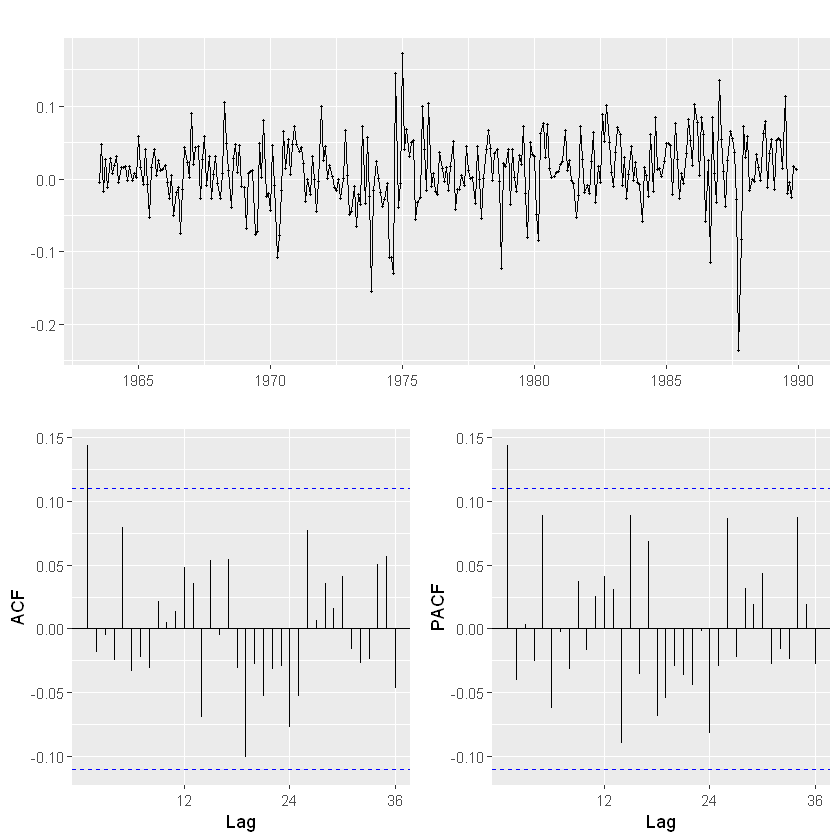

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 0

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1     ma1    mean
      -0.8161  0.9237  0.0108
s.e.   0.0929  0.0647  0.0027

sigma^2 estimated as 0.002144:  log likelihood=527.28
AIC=-1046.55   AICc=-1046.43   BIC=-1031.51


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with non-zero mean
Q* = 15.08, df = 21, p-value = 0.8189

Model df: 3.   Total lags used: 24



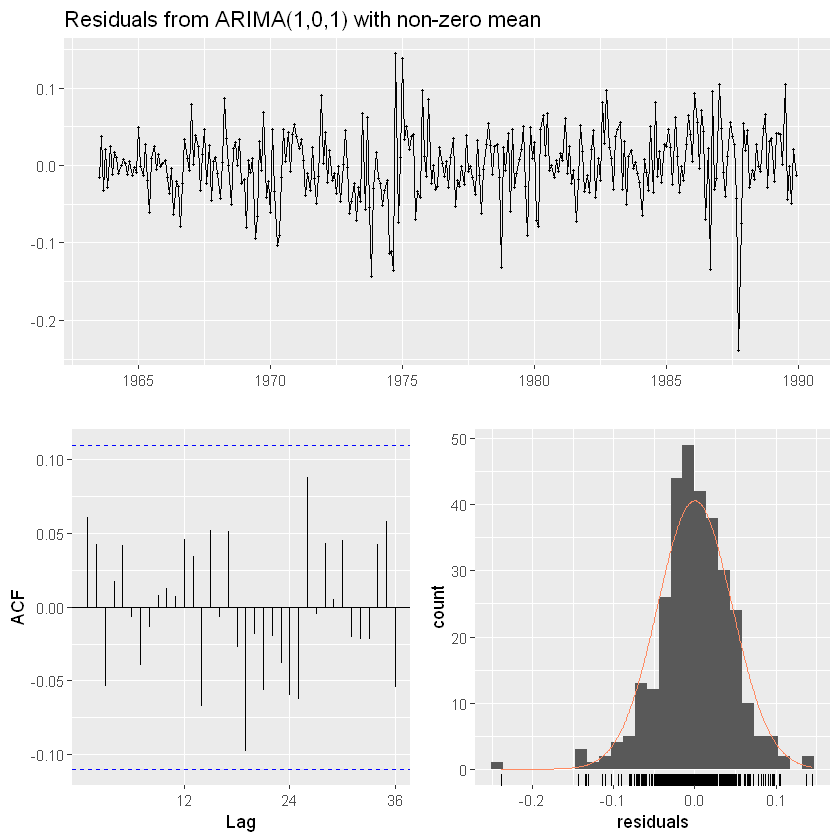

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(1,0,1), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [13]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2))

In [14]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-1040.083,-1040.045,-1032.559,4.690380
ARIMA001,-1045.138,-1045.061,-1033.852,4.645370
ARIMA002,-1043.294,-1043.166,-1028.246,4.643768
ARIMA100,-1044.713,-1044.637,-1033.427,4.648269
ARIMA101,-1046.555,-1046.427,-1031.507,4.613381
ARIMA102,-1048.395,-1048.202,-1029.585,4.578979
ARIMA200,-1043.226,-1043.098,-1028.178,4.644451
ARIMA201,-1048.383,-1048.190,-1029.573,4.580579
ARIMA202,-1046.408,-1046.138,-1023.836,4.580294


Mô hình ARIMA(1,0,2) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(1,0,2) trên tập test

In [12]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(1,0,2))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 3.826576

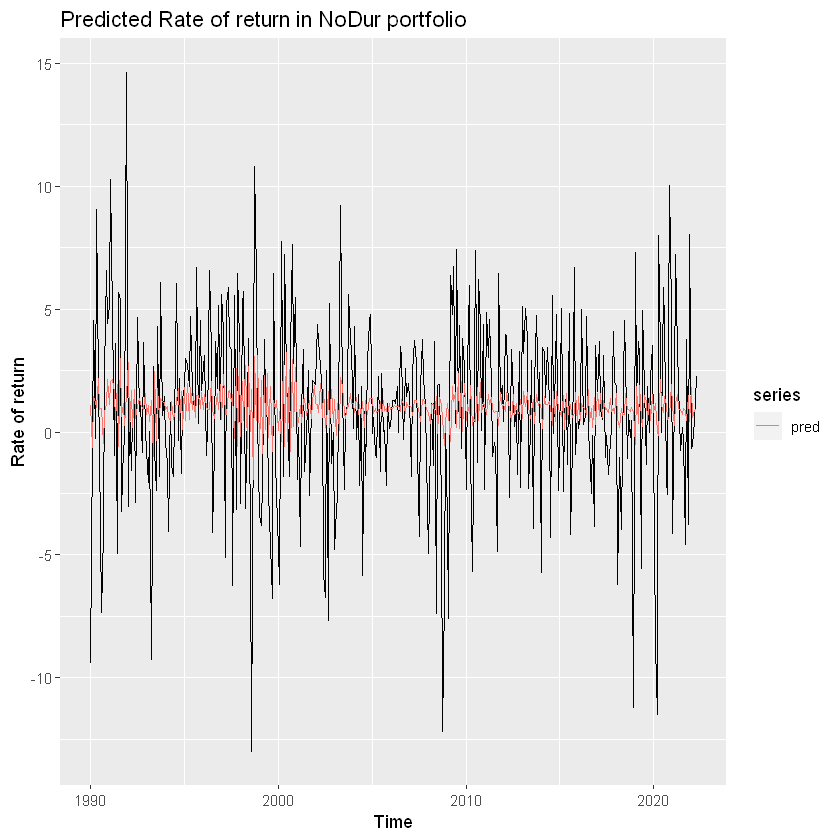

In [13]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in NoDur portfolio")

In [14]:
as.numeric(pred)

[1]  1.083812582 -0.628612442  1.430073703  1.222016236  1.014468674
  [6]  2.162585616  0.917841204  0.950110590 -0.459715737  0.780249313
 [11]  1.112280106  2.140275857  1.102638656  2.046302038  2.150978752
 [16]  1.614321135  0.486121714  1.949950385 -0.572488103  2.980292986
 [21]  0.636590031  1.172727260  0.250506410  1.547547123  2.820360762
 [26]  0.040831782  1.690302974  0.176175540  1.742981295  0.534116845
 [31]  1.053872806  1.352500140  1.172031245  0.993443452  0.899487123
 [36]  1.571618171  0.717933616  1.071341694  0.448403766  1.301961506
 [41] -1.010574381  2.467112613 -0.361798988  1.769810679  0.579262331
 [46]  1.366728205  1.262004186  1.220801149  0.908500830  1.020152044
 [51]  0.604147087  0.486241261  1.231057769  0.519617971  0.888455573
 [56]  1.265193500  1.771676077  0.474065589  1.648958630  0.109568571
 [61]  1.792820737  0.465694890  1.985993989  0.528370099  1.818806463
 [66]  0.918997835  1.585411356  0.600744760  1.480075283  1.498847552
 [71]  0.973923079  1.627363304  0.913445836  1.535315861  1.088792927
 [76]  0.916411692  0.933295699  2.039766579  0.924462445  0.560637529
 [81]  0.907213526  1.578737002  0.930496730  1.936270755  0.492823349
 [86]  2.344215830  0.706161146  0.722320172  1.611222386  1.694755517
 [91]  1.259885441  1.510066128 -0.277743255  2.604723015 -0.583080081
 [96]  3.226989309 -0.191608085  2.067091349  0.461973883  2.716571324
[101] -0.684789601  2.665091053  0.017652282  1.742473764 -1.920085051
[106]  3.055400537  0.477295761  3.107943887 -0.553001015  2.092074066
[111] -0.861797562  2.283095134  0.103917174  2.378205764 -0.241520219
[116]  1.866147140 -0.792449646  1.273845333  0.975818635  1.285335520
[121]  0.076260163  0.847403876 -0.402003852  2.887082478 -0.585549277
[126]  3.239460910 -0.393305591  2.530661057 -0.777402664  2.968911146
[131]  0.226771390  2.620039386  0.235301830  0.478011185  1.079883175
[136]  0.381086094  1.319371670  1.357862559  0.663678806  1.039637582
[141]  1.296174356  0.563955695  1.233708464  1.893730093  1.140937279
[146]  1.118185022  0.787943733  1.982148168  0.586995786  1.727656711
[151]  0.167967457  0.359247173  1.655128906  0.167805092  1.721292241
[156]  0.398232308  1.309207099 -0.156208550  1.141785546  0.053157504
[161]  2.203722475  1.870331992  0.789349930  0.548425314  1.072692533
[166]  1.038404201  1.565116153  1.153461643  1.174579417  0.786712606
[171]  1.420765383  0.728397434  1.128266910  0.609655085  1.259229472
[176]  0.173715126  1.287830704  0.714856032  1.352797624  1.373749485
[181]  1.349545144  0.741117367  0.976643106  0.798146182  0.842337048
[186]  1.242372028  0.678770549  1.273417456  0.863896461  0.942953644
[191]  0.665957201  1.145000345  0.919143866  0.961482106  1.077187886
[196]  1.045887776  1.023846956  1.096825972  0.850590275  1.330710429
[201]  1.158025850  0.769831040  1.217007621  1.025404951  1.099195536
[206]  1.011407002  0.655316509  1.289302552  1.282288639  1.133585577
[211]  0.717482525  0.415205614  1.312276226  1.333364843  1.075659373
[216]  0.968826158  0.747677659  0.360577243  1.109049263  1.121437726
[221]  0.754048503  1.435043850 -0.076135161  1.412288783  1.106064867
[226]  0.530913996 -0.537047011  0.410151147  1.178700580  0.707420667
[231] -0.402199086  1.833268714  1.226753318  1.611901361  0.177484239
[236]  2.377142140  0.139975958  2.061118258  0.037847249  1.978249943
[241]  0.487703982  1.113706536  0.757719364  1.878453081  0.273643360
[246]  0.575500119  0.443022499  1.804824505  0.486912525  2.034716216
[251]  0.814825439  1.196506921  1.098757375  0.694586412  1.534708132
[256]  1.125000921  1.401881176  0.963335463  0.803556486  0.829839360
[261]  0.826513439  0.257580694  1.599685994  0.947635755  1.119291496
[266]  0.849369605  1.598110423  1.177974197  1.009538318  0.415023416
[271]  1.541103466  0.720359949  1.158668948  0.731317438  0.848202136
[276]  1.318745250  0.570502077  1.631845921  1.022518267  1.627973347
[281]  1.055249868  0.5534